# Introduction

In this notebook I will attempt to predict automobile prices using Python and its data analysis and machine learning packages such as `pandas` and `scikit-learn`. Forecasting car prices can be useful for businesses in general: insurance companies can use this information to calculate their premia; websites and enterprises can provide estimates even when asking prices are not available in a specific application; enterprises can set contracts where a car's resale value must be defined _a priori_ with greater information, or determine if a car is overvalued or undervalued with respect to the market.

My data source is [Mercado Livre](www.mercadolivre.com.br), a widely used e-commerce platform in Brazil. For simplicity, and also to isolate other geographical factors that affect prices, this research restricts to ads in the city of Porto Alegre/RS. I also excluded trucks and minivans from the analysis. While new cars can be announced, most of the cars advertised are used. To publish an ad, the seller must fill information about the car, such as brand, model, mileage, engine power and additional features. It is a common belief that this features can help predict a car's asking price in the market, and in our methodology I will explore them to improve our predictions (of course, there also will be unobservable factors that affect prices). A popular source for automobile prices in Brazil is the [FIPE table](http://www.veiculos.fipe.org.br/). In the table, average prices are calculated from newspaper and web ads. Data from the FIPE table can be improved here, as learning models can benefit from data updates, predict prices for cars with a specific set of features and location.

Along the notebook, I will go through all steps of data analysis, with code and commentary.

# Data wrangling

First, let's import the required packages for this step:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import json
import requests

# API token
from kaggle_secrets import UserSecretsClient
secret_label = "mltoken"
token = UserSecretsClient().get_secret(secret_label)

To access data on ads, I'll make requests to the MercadoLivre's API. We must build the query URL, using category and location identifiers that can be found in the API [documentation site](http://developers.mercadolivre.com.br/).

In [2]:
# parameters
category = 'MLB1744' # cars and trucks
city     = 'TUxCUFJJT0xkYzM0' # state of rs
limit    = '50'
offset   = [str(i) for i in list(range(50,10000,50))]

Users are only allowed to fetch 50 items per request - up to 10000 items - and this is controlled by the `offset` parameter. Using `requests`, we can download all data:

In [3]:
responses = []
for off in offset:
    url = 'https://api.mercadolibre.com/sites/MLB/search?category='+category+'&state='+city+'&limit='+limit+'&offset='+off+'&access_token='+token
    #print(url)
    responses.append(requests.get(url))

respd = [i.json() for i in responses]

The `.json` method transforms the data into a Python dictionary. Looking at the structure of data, I find that ad entries are stored under key `results`:

In [4]:
respd[0].keys()

dict_keys(['site_id', 'paging', 'results', 'secondary_results', 'related_results', 'sort', 'available_sorts', 'filters', 'available_filters'])

In [5]:
# tests
data1 = [pd.io.json.json_normalize(i['results'], sep='_') for i in respd]

The result is a list of pandas DataFrames. We can append all datasets using `concat`:

In [6]:
data1 = pd.concat(data1, sort=False).reset_index(drop=True)
data1.head()

,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,...,seller_address_city,seller_eshop_nick_name,seller_eshop_eshop_rubro,seller_eshop_eshop_id,seller_eshop_eshop_locations,seller_eshop_site_id,seller_eshop_eshop_logo_url,seller_eshop_eshop_status_id,seller_eshop_seller,seller_eshop_eshop_experience
0,MLB1407588422,MLB,Fiat Mobi 1.0 8v Evo Flex Easy Manual,25990,BRL,1,0,classified,gold_premium,2020-01-27T04:00:00.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLB1406096929,MLB,Fiat Fiorino 1.4 Mpi Furgão Hard Working 8v Fl...,47890,BRL,1,0,classified,gold_premium,2020-01-27T04:00:00.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MLB1401139446,MLB,Ford Ka 1.5 Se 16v Flex 4p Manual,37990,BRL,1,0,classified,gold_premium,2020-01-27T04:00:00.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MLB1400452685,MLB,Chevrolet Onix 1.0 Mpfi Joy 8v Flex 4p Manual,36490,BRL,1,0,classified,gold_premium,2020-02-21T09:15:24.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MLB1399889465,MLB,Ford Ka + 1.5 Se 16v Flex 4p Manual,41490,BRL,1,0,classified,gold_premium,2020-02-21T09:15:24.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In each entry, we have a series of characteristics on the car, such as make, model, asking price, features and location. Next, I will transform the data into a pandas DataFrame for further manipulation. This requires a few steps, as the data is structured in a list of dicts:

In [7]:
cols = ['title','price','address_city_name','attributes', 'id',
       'location_latitude', 'location_longitude',
       'permalink',
       'seller_car_dealer']

data1 = data1.loc[:,cols]
data1.head()

,title,price,address_city_name,attributes,id,location_latitude,location_longitude,permalink,seller_car_dealer
0,Fiat Mobi 1.0 8v Evo Flex Easy Manual,25990,Caxias do Sul,"[{'name': 'Condição do item', 'value_name': 'U...",MLB1407588422,-29.147295,-51.161154,https://carro.mercadolivre.com.br/MLB-14075884...,True
1,Fiat Fiorino 1.4 Mpi Furgão Hard Working 8v Fl...,47890,Caxias do Sul,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",MLB1406096929,-29.147295,-51.161154,https://carro.mercadolivre.com.br/MLB-14060969...,True
2,Ford Ka 1.5 Se 16v Flex 4p Manual,37990,Caxias do Sul,"[{'attribute_group_name': '', 'name': 'Condiçã...",MLB1401139446,-29.147295,-51.161154,https://carro.mercadolivre.com.br/MLB-14011394...,True
3,Chevrolet Onix 1.0 Mpfi Joy 8v Flex 4p Manual,36490,Porto Alegre,"[{'name': 'Condição do item', 'value_id': '223...",MLB1400452685,-29.999978,-51.198601,https://carro.mercadolivre.com.br/MLB-14004526...,True
4,Ford Ka + 1.5 Se 16v Flex 4p Manual,41490,Porto Alegre,"[{'id': 'ITEM_CONDITION', 'value_id': '2230581...",MLB1399889465,-29.999978,-51.198601,https://carro.mercadolivre.com.br/MLB-13998894...,True


It's a great step forward, however information on a car's attributes are still trapped in a list of dicts. Hence any attempts at using the previous `json_serialize` method will fail. As an example, let's apply the function to the feature alone:

In [8]:
pd.io.json.json_normalize(data1.attributes[0], sep='_').head()

,name,value_name,value_struct,attribute_group_id,id,value_id,values,attribute_group_name,source,value_struct_number,value_struct_unit
0,Condição do item,Usado,NaN,,ITEM_CONDITION,2230581,"[{'id': '2230581', 'name': 'Usado', 'struct': ...",,1,NaN,NaN
1,Transmissão,Manual,NaN,ADICIONALES,TRANSMISSION,370877,"[{'id': '370877', 'name': 'Manual', 'struct': ...",Adicionais,7810940008532,NaN,NaN
2,Marca,Fiat,NaN,FIND,BRAND,67781,"[{'struct': None, 'source': 1, 'id': '67781', ...",Ficha técnica,1,NaN,NaN
3,Portas,4,NaN,FIND,DOORS,None,"[{'id': None, 'name': '4', 'struct': None, 'so...",Ficha técnica,7810940008532,NaN,NaN
4,Tipo de combustível,Gasolina e álcool,NaN,FIND,FUEL_TYPE,372591,"[{'id': '372591', 'name': 'Gasolina e álcool',...",Ficha técnica,7810940008532,NaN,NaN


Now, I will reshape the data in order to have a single row per advertising. Let's define a helper function:

In [9]:
def reshape_(data):
    return data.loc[:,['id','value_name']].set_index('id').transpose()

We must now loop over samples and then join all data. _For_ loops can be avoided, using Python's list comprehensions:

In [10]:
df_temp = [reshape_(pd.io.json.json_normalize(i)) for i in data1.attributes]

data2 = pd.concat(df_temp, sort=False).reset_index(drop=True)
del df_temp
data2.tail()

,ITEM_CONDITION,TRANSMISSION,BRAND,DOORS,FUEL_TYPE,KILOMETERS,MODEL,TRIM,VEHICLE_YEAR,TRACTION_CONTROL,ENGINE_DISPLACEMENT
9942,Usado,Automática,Land Rover,4,Gasolina,61000 km,Range Rover,EVOQUE PRESTIGE TECH,2013,NaN,NaN
9943,Usado,Manual,Ford,4,Gasolina e álcool,132 km,Focus Sedan,2.0 16V Flex 5p,2013,NaN,NaN
9944,Usado,Automática,Hyundai,4,Gasolina,97000 km,i30,2.0 16V 145cv Aut. ** Bancos Couro **,2011,NaN,NaN
9945,Usado,Manual,Geely,4,Gasolina,34000 km,GC2,GL 1.0 CVVT 12V 68cv 5p,2015,NaN,NaN
9946,Usado,Manual,Renault,4,Gasolina e álcool,82000 km,Megane,1.6 DYNAMIQUE GRAND TOUR 16V FLEX 4P MANUAL,2012,NaN,NaN


Finally, we'll merge with the original data:

In [11]:
df = pd.concat([data1,data2], axis=1)

In [12]:
df.head()

,title,price,address_city_name,attributes,id,location_latitude,location_longitude,permalink,seller_car_dealer,ITEM_CONDITION,TRANSMISSION,BRAND,DOORS,FUEL_TYPE,KILOMETERS,MODEL,TRIM,VEHICLE_YEAR,TRACTION_CONTROL,ENGINE_DISPLACEMENT
0,Fiat Mobi 1.0 8v Evo Flex Easy Manual,25990,Caxias do Sul,"[{'name': 'Condição do item', 'value_name': 'U...",MLB1407588422,-29.147295,-51.161154,https://carro.mercadolivre.com.br/MLB-14075884...,True,Usado,Manual,Fiat,4,Gasolina e álcool,38593 km,Mobi,1.0 8V EVO FLEX EASY MANUAL,2018,NaN,NaN
1,Fiat Fiorino 1.4 Mpi Furgão Hard Working 8v Fl...,47890,Caxias do Sul,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",MLB1406096929,-29.147295,-51.161154,https://carro.mercadolivre.com.br/MLB-14060969...,True,Usado,Manual,Fiat,2,Gasolina e álcool,51233 km,Fiorino,1.4 MPI FURGÃO HARD WORKING 8V FLEX 2P MANUAL,2018,NaN,NaN
2,Ford Ka 1.5 Se 16v Flex 4p Manual,37990,Caxias do Sul,"[{'attribute_group_name': '', 'name': 'Condiçã...",MLB1401139446,-29.147295,-51.161154,https://carro.mercadolivre.com.br/MLB-14011394...,True,Usado,Manual,Ford,4,Gasolina e álcool,46358 km,Ka,1.5 SE 16V FLEX 4P MANUAL,2018,NaN,NaN
3,Chevrolet Onix 1.0 Mpfi Joy 8v Flex 4p Manual,36490,Porto Alegre,"[{'name': 'Condição do item', 'value_id': '223...",MLB1400452685,-29.999978,-51.198601,https://carro.mercadolivre.com.br/MLB-14004526...,True,Usado,Manual,Chevrolet,4,Gasolina e álcool,59605 km,Onix,1.0 MPFI JOY 8V FLEX 4P MANUAL,2018,NaN,NaN
4,Ford Ka + 1.5 Se 16v Flex 4p Manual,41490,Porto Alegre,"[{'id': 'ITEM_CONDITION', 'value_id': '2230581...",MLB1399889465,-29.999978,-51.198601,https://carro.mercadolivre.com.br/MLB-13998894...,True,Usado,Manual,Ford,4,Gasolina e álcool,57818 km,Ka,1.5 SE 16V FLEX 4P MANUAL,2018,NaN,NaN


Some more data cleaning, to deal with strings and data types:

In [13]:
df.drop(['TRIM','ITEM_CONDITION','title','attributes','id','permalink'], axis=1, inplace=True)
df.columns = map(str.lower, df.columns)

#remove unwanted strings
cols = ['location_latitude', 'location_longitude','engine_displacement','kilometers','vehicle_year','doors']
df.loc[:,cols] = df.loc[:,cols].replace(regex=True,to_replace=r'\D',value=r'')

# replace empty strings with NaN
df.replace({'':np.nan}, inplace=True)

# set brand and model strings to lowercase
df.brand = df.brand.str.lower()
df.model = df.model.str.lower()

In [14]:
# type conversion
df = df.astype({'location_latitude':float, 'location_longitude':float,'engine_displacement':float,
                'kilometers':float,'vehicle_year':float,'doors':float})

df.dtypes

price                    int64
address_city_name       object
location_latitude      float64
location_longitude     float64
seller_car_dealer         bool
transmission            object
brand                   object
doors                  float64
fuel_type               object
kilometers             float64
model                   object
vehicle_year           float64
traction_control        object
engine_displacement    float64
dtype: object

Now, I will attempt to detect outliers in numerical features. We must note that some extreme values are not outliers (i.e. we will have feature `kilometers` set to zero for new cars). Outlier detection will generate missing values that must be treated later.

In [15]:
df.describe().round(2)

,price,location_latitude,location_longitude,doors,kilometers,vehicle_year,engine_displacement
count,9.947000e+03,9824.00,9824.00,9947.00,9.947000e+03,9947.00,3444.00
mean,2.372200e+05,-29.33,-51.14,3.97,2.989408e+05,2012.79,1852.32
std,1.148189e+07,5.35,4.12,0.77,1.422604e+07,5.32,4419.83
min,1.000000e+01,-33.69,-119.42,0.00,0.000000e+00,1963.00,1.00
25%,2.790000e+04,-30.03,-51.22,4.00,3.193750e+04,2011.00,1368.00
50%,3.980000e+04,-29.94,-51.19,4.00,6.300000e+04,2014.00,1598.00
75%,6.000000e+04,-29.64,-51.14,4.00,9.489250e+04,2016.00,1997.00
max,9.000000e+08,41.40,2.17,7.00,1.000000e+09,2020.00,174696.00


In [16]:
# fix extreme values
df.price.replace({df.price.max(): np.nan}, inplace=True)
df.engine_displacement[df.engine_displacement < 900] = np.nan
df.engine_displacement[df.engine_displacement > 4000] = np.nan
df.kilometers.replace({df.kilometers.max(): np.nan}, inplace=True)
df.vehicle_year.replace({df.vehicle_year.min(): np.nan}, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Finally, we must deal with missing values, since `scikit-learn` does not accept them. It is often more fruitful to fill in missing values, rather than dropping whole samples.

In [17]:
# find missing values
df.isna().sum()

price                     1
address_city_name         0
location_latitude       123
location_longitude      123
seller_car_dealer         0
transmission            314
brand                     0
doors                     0
fuel_type                 0
kilometers                2
model                     0
vehicle_year              1
traction_control       5722
engine_displacement    6553
dtype: int64

In [18]:
df.transmission       = df.transmission.fillna('Manual')
df.kilometers         = df.kilometers.fillna(df.kilometers.mean())
df.price              = df.price.fillna(df.price.mean())
df.traction_control   = df.traction_control.fillna('Dianteira')
df.location_latitude  = df.location_latitude.fillna(method='ffill')
df.location_longitude = df.location_longitude.fillna(method='ffill')
df.vehicle_year       = df.vehicle_year.fillna(df.vehicle_year.mean())

Features `engine_displacement` still exhibit lots of missing values. For `engine_displacement`, my strategy was to fill with the mode (or median) values of features according to each car model. This seems to be a better approach than filling with the average engine size of all cars.

In [19]:
import statistics
def mode_or_median(var):
    try:
        return statistics.mode(var)
    except statistics.StatisticsError: # there may be no unique value
        return np.median(var)

In [20]:
avg_eng = df.groupby('model')['engine_displacement'].apply(mode_or_median)
avg_eng.fillna(avg_eng.median(),inplace=True) # fill the remaining NaN's
avg_eng.sample(10)

model
boxster         1796.0
cherokee        3701.0
pajero sport    3497.0
elantra         1998.0
180-d           1796.0
serie 3         1796.0
coupe           1796.0
classe b        1796.0
ix35            1999.0
discovery       1796.0
Name: engine_displacement, dtype: float64

Now, we will insert the average values only when data were initially missing:

In [21]:
df.set_index('model', drop=False, inplace=True)
df.update(avg_eng, overwrite=False) # overwrite=False only updates NaN's
df.reset_index(drop=True, inplace=True)

Last, I will drop extreme values from our target distribution of car prices. First, because luxury car prices are harder to predict (because of fewer data points), and also because some entries are just wrong (i.e. ads for older cars whose prices have been mistyped).

In [22]:
# keep values within interval
df = df[(df.price > df.price.quantile(0.01)) & (df.price < df.price.quantile(0.99))]

Finally, we have a dataset ready for analysis:

In [23]:
df.head()

,price,address_city_name,location_latitude,location_longitude,seller_car_dealer,transmission,brand,doors,fuel_type,kilometers,model,vehicle_year,traction_control,engine_displacement
0,25990.0,Caxias do Sul,-29.147295,-51.161154,True,Manual,fiat,4.0,Gasolina e álcool,38593.0,mobi,2018.0,Dianteira,999.0
1,47890.0,Caxias do Sul,-29.147295,-51.161154,True,Manual,fiat,2.0,Gasolina e álcool,51233.0,fiorino,2018.0,Dianteira,1368.0
2,37990.0,Caxias do Sul,-29.147295,-51.161154,True,Manual,ford,4.0,Gasolina e álcool,46358.0,ka,2018.0,Dianteira,997.0
3,36490.0,Porto Alegre,-29.999978,-51.198601,True,Manual,chevrolet,4.0,Gasolina e álcool,59605.0,onix,2018.0,Dianteira,999.0
4,41490.0,Porto Alegre,-29.999978,-51.198601,True,Manual,ford,4.0,Gasolina e álcool,57818.0,ka,2018.0,Dianteira,997.0


# Exploratory data analysis

First, let's check descriptive statistics:

In [24]:
df.describe(include='all').round(2)

,price,address_city_name,location_latitude,location_longitude,seller_car_dealer,transmission,brand,doors,fuel_type,kilometers,model,vehicle_year,traction_control,engine_displacement
count,9737.00,9737,9737.00,9737.00,9737,9737,9737,9737.00,9737,9.737000e+03,9737,9737.00,9737,9737.00
unique,NaN,186,NaN,NaN,2,4,52,NaN,16,NaN,475,NaN,6,NaN
top,NaN,Porto Alegre,NaN,NaN,True,Manual,chevrolet,NaN,Gasolina e álcool,NaN,onix,NaN,Dianteira,NaN
freq,NaN,3792,NaN,NaN,8610,5705,1437,NaN,6542,NaN,270,NaN,8363,NaN
mean,50638.31,NaN,-29.33,-51.14,NaN,NaN,NaN,3.98,NaN,9.399908e+04,NaN,2012.93,NaN,1655.66
std,36833.42,NaN,5.38,4.14,NaN,NaN,NaN,0.75,NaN,1.167588e+06,NaN,5.10,NaN,542.20
min,8900.00,NaN,-33.69,-119.42,NaN,NaN,NaN,0.00,NaN,0.000000e+00,NaN,1965.00,NaN,970.00
25%,28700.00,NaN,-30.03,-51.22,NaN,NaN,NaN,4.00,NaN,3.200000e+04,NaN,2011.00,NaN,1339.00
50%,39800.00,NaN,-29.94,-51.19,NaN,NaN,NaN,4.00,NaN,6.368000e+04,NaN,2014.00,NaN,1598.00
75%,59900.00,NaN,-29.64,-51.14,NaN,NaN,NaN,4.00,NaN,9.400000e+04,NaN,2016.00,NaN,1984.00


The `describe` method is very useful to find strange values left in data, such as found in _engine displacement_ and _kilometers_.

The correlation matrix:

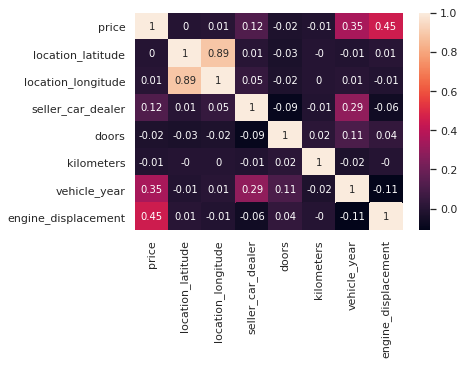

In [25]:
sns.heatmap(df.corr().round(2), annot=True)

The most popular cars announced and the average price:

In [26]:
df.groupby(['brand','model']).agg({'price':['mean','count']}).sort_values(('price','count'), ascending=False)[:10]

price      
                             mean count
brand      model                       
chevrolet  onix      39313.700000   270
renault    sandero   33448.488189   254
volkswagen gol       27493.399209   253
ford       fiesta    31357.462555   227
           ka        35335.251142   219
           ecosport  47848.888889   216
fiat       palio     23998.556650   203
chevrolet  prisma    38507.751479   169
toyota     corolla   57614.053254   169
fiat       uno       26541.528662   157

The same query as before, now considering the manufacturing year of the cars:

In [27]:
df.groupby(['brand','model','vehicle_year']).agg({'price':['mean','count']}).sort_values(('price','count'), ascending=False)[:10]

price      
                                           mean count
brand      model    vehicle_year                     
chevrolet  onix     2019.0         40970.886076    79
ford       ka       2018.0         40143.461538    78
renault    sandero  2019.0         39859.583333    72
volkswagen gol      2019.0         39231.403509    57
chevrolet  onix     2018.0         42293.921569    51
jeep       renegade 2016.0         70203.260870    46
ford       fiesta   2014.0         30614.186047    43
jeep       compass  2018.0        111564.634146    41
renault    logan    2019.0         40263.658537    41
fiat       palio    2013.0         28243.076923    39

Here are the most expensive brands, by average price:

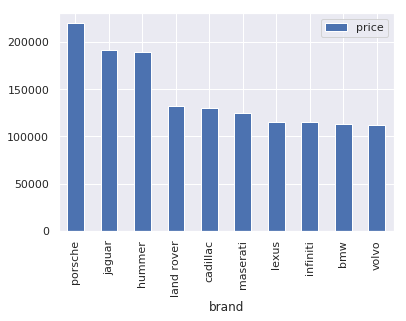

In [28]:
df.pivot_table(index=['brand'], values=['price'], aggfunc=np.mean).round(2).sort_values('price', ascending=False)[:10].plot.bar()

How cars are located geographically:

/opt/conda/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


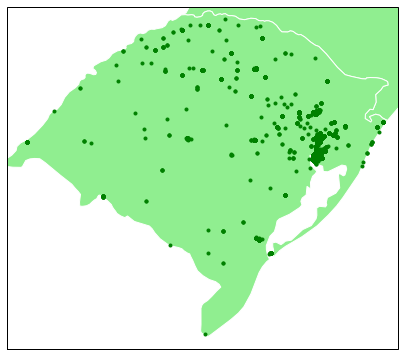

In [29]:
import cartopy.crs as ccrs
from cartopy.io import shapereader

kw = dict(resolution='50m', category='cultural',
          name='admin_1_states_provinces')

states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(7, 11),
                       subplot_kw=subplot_kw)
ax.set_extent([-57.5,-49.5, -34,-27])
ax.add_geometries(shp.geometries(), ccrs.PlateCarree(), facecolor='lightgreen')
ax.scatter(df.location_longitude, df.location_latitude, marker='.', c='green', zorder=2)

The relationship between continuous features are key in our dataset. Are they linear? This is important as most models assume a linear relationship between features and the target.

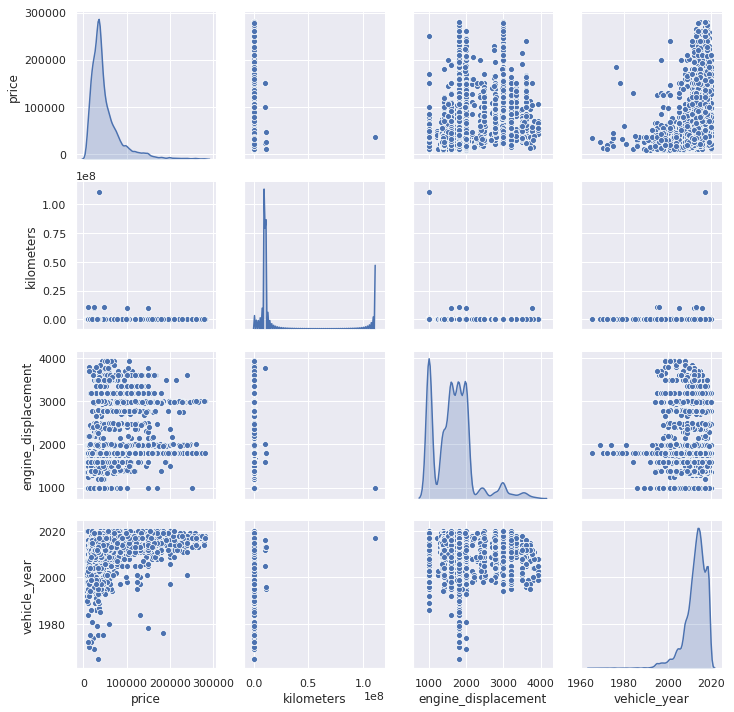

In [30]:
sns.pairplot(df[['price','kilometers','engine_displacement','vehicle_year']], diag_kind='kde')

# Model tests

First, let's identify the scope of our problem. Our target, `price`, is continuous, so we're dealing with a regression problem. In this section I will experiment with different regression techniques. But first, the dataset must be further processed: our categorical features must be translated into numeric. This can be done in pandas with `get_dummies` (or in scikit-learn with `OneHotEncoder`): it transforms a categorical feature into dummy variables that indicate which category an observation belongs.'

My theoretical model is currently specified as (simplified):

$price_i = model_i + year_i + features_i + error_i$

In a regression context, this means that all auto models depreciate at a rate determined by the coefficient associated with $year$. However, one would expect each model to lose value at a different rate (i.e. luxury, fuel-efficient or low-maintenance cars would preserve their value for longer). We can implement this by interacting features $model$ and $year$, that is, $price_i = modelyear_i + features_i + error_i$. The downside of this approach is that it may lead to overfitting.

Let's load the `scikit-learn` methods:

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics

# disable standard scaler data conversion warning
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

X = df.drop(['price','address_city_name'], axis=1).copy()
y = df.price.values.copy() # prices in R$

Next, I split the data in both training and data sets. Training data will be used to fit the model, and the test set to assess model accuracy.

In [32]:
# generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In addition, we can perform standardization (centering of data around the average, also called scaling) of our numerical features using `StandardScaler`. Standardization can improve the accuracy of most models, on the other hand we lose interpretation of model coefficients such as the ones given by linear regression. Fortunately, we can use the `predict` method to give us model predictions. This step will be done inside a pipeline, after training and test data splits, to avoid [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/).

In [33]:
# categorical features
cat_ft = ['seller_car_dealer', 'transmission', 'brand', 'fuel_type', 'model', 'traction_control']

# run once on full dataset to get all category values
temp = ColumnTransformer([('cat', OneHotEncoder(), cat_ft)]).fit(X)
cats = temp.named_transformers_['cat'].categories_

cat_tr = OneHotEncoder(categories=cats, sparse=False)

# numerical features
num_ft = ['location_latitude', 'location_longitude', 'engine_displacement', 'doors', 'kilometers', 'vehicle_year']
num_tr = StandardScaler()
#num_tr = FunctionTransformer(func=None)

# data transformer
data_tr = ColumnTransformer([('num', num_tr, num_ft), ('cat', cat_tr, cat_ft)])

## Model comparison

There are a lot of techniques that can be used in a regression problem. As a starting point, I will compare some of them in terms of scores and sum of errors:

In [34]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn import ensemble

models = [DummyRegressor(),
          KNeighborsRegressor(),
          #linear_model.LinearRegression(), # ommited because of negative scores
          linear_model.Lasso(),
          linear_model.Ridge(),
          linear_model.ElasticNet(),
          ensemble.GradientBoostingRegressor(),
          ensemble.RandomForestRegressor(),
          ensemble.ExtraTreesRegressor()]

models_names = ['Dummy','K-nn','Lasso','Ridge','Elastic','Boost','Forest','Extra']

In [35]:
scores = []
mse = []
mae = []

for model in models:
    pipe = Pipeline([
    ('features', data_tr),
    ('model', model)
    ])
    fits = pipe.fit(X_train,y_train)
    scores.append(metrics.r2_score(y_test, fits.predict(X_test)))
    mse.append(metrics.mean_squared_error(y_test, fits.predict(X_test)))
    mae.append(metrics.median_absolute_error(y_test, fits.predict(X_test)))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3596188841.248047, tolerance: 918105823.2719475
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Let's take a look at the model $R^2$ scores (more is better), mean squared error and median absolute error (less is better):

Text(0, 0.5, 'Median absolute error')

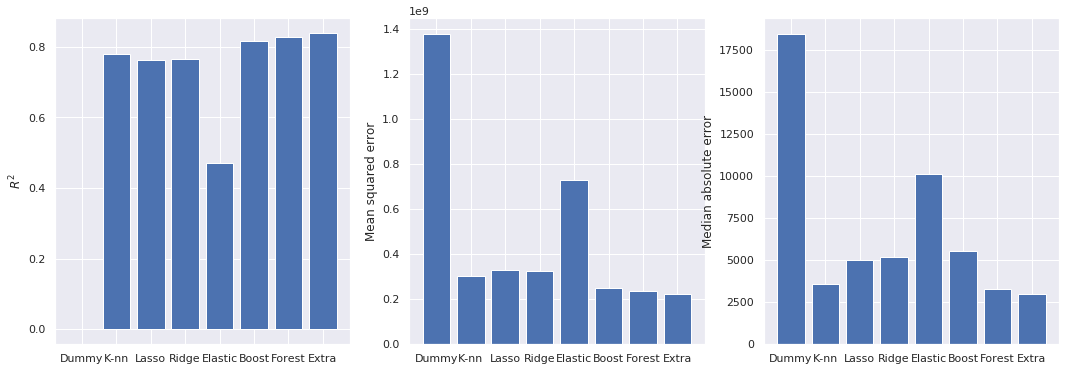

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=False, figsize=(18,6))
ax1.bar(models_names, scores)
ax1.set_ylabel('$R^2$')
ax2.bar(models_names, mse)
ax2.set_ylabel('Mean squared error')
ax3.bar(models_names, mae)
ax3.set_ylabel('Median absolute error')

All model scores are calculated using regression residuals, so they are correlated. The $R^2$ score in most models performed at around 0.8, except the elastic net model, which peaked at 0.5 in the training set. Gradient boosting, random forest and extra trees had the best scores. However, $R^2$ scores should be taken with precaution as they are biased towards larger models. Mean squared error (MSE) is a metric that penalizes larger prediction errors. Last are the median absolute error (MAE). Absolute error measures are interesting because they inform average deviations in terms of our target (predicted car prices, in our case).

I'll stick with the random forest regressor, as it was less prone to overfitting in previous tests.

## Predictions

Now, we fit the chosen model and extract some predictions:

In [37]:
mod = Pipeline([
    ('features', data_tr),
    ('model', ensemble.RandomForestRegressor(n_estimators=100, min_samples_leaf=1))])

mod_fit = mod.fit(X_train, y_train)

mod_fit.score(X_test,y_test)

0.843460922958776

Some example predictions from the model:

In [38]:
pred = pd.DataFrame.from_dict({'predicted':mod_fit.predict(X_test), 'true':y_test})
pred['difference'] = pred.predicted - pred.true
pred.sample(n=10).round(2)

,predicted,true,difference
2480,41356.50,38000.0,3356.50
332,25047.35,28500.0,-3452.65
2612,64611.37,59900.0,4711.37
170,33458.37,31900.0,1558.37
48,70619.20,69900.0,719.20
2300,11152.30,8900.0,2252.30
2653,61661.30,66900.0,-5238.70
1994,37622.40,36460.0,1162.40
679,28294.23,28900.0,-605.77
293,41089.40,49500.0,-8410.60


The average prediction error in car prices is around -R$600. The value being negative means that the model tends to underestimate prices in general. The not-so-good news is that the standard deviation of predictions is pretty high.

In [39]:
pred.difference.describe()

count      2922.000000
mean       -994.107238
std       14655.124251
min     -225507.300000
25%       -2730.400000
50%         319.995000
75%        3195.550000
max       72687.400000
Name: difference, dtype: float64

## Model tuning

The random forest regressor have a few hyperparameters that can be tuned to improve overall accuracy. I will play around with `n_estimators` (the number of estimators/trees) and `min_samples_leaf` (the minimum number of samples to be in a tree branch). One might be tempted to test all parameters, but the computational costs quickly grow according to the number of parameters, possible values and cross-validation folds:

In [40]:
from sklearn.model_selection import GridSearchCV

# cross validation folds
folds=3

# set parameter range for grid search
params = {'model__n_estimators': [10, 20, 30, 50, 100], 'model__min_samples_leaf': [1,2]}

grids = GridSearchCV(mod, param_grid=params, cv=folds)
grids_fit = grids.fit(X_train, y_train)

print('Best choice of parameter:', grids_fit.best_params_)

Best choice of parameter: {'model__min_samples_leaf': 1, 'model__n_estimators': 100}


# Validation

First, I will perform a three-fold cross validation (that is, calculate training and test scores for three random sub-samples of data) and take the mean of scores:

In [41]:
from sklearn.model_selection import cross_validate

mod_cross_val = cross_validate(mod, X, y=y, cv=folds, return_train_score=True)

print('Average train score:', mod_cross_val['train_score'].mean().round(4))
print('Average test score:',  mod_cross_val['test_score'].mean().round(4))

Average train score: 0.9755
Average test score: 0.8075


Next, the learning curve tells us how model prediction improves as we add training samples (that's when the machine is _learning_):

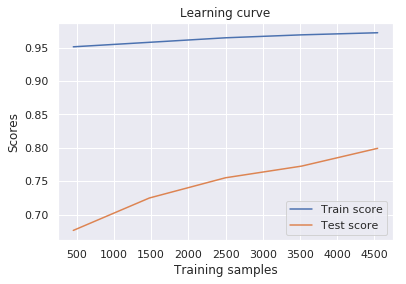

In [42]:
from sklearn.model_selection import learning_curve

learn_tr_size, learn_train_sc, learn_test_sc = learning_curve(mod, X_train, y_train, cv=folds)

# calculate mean over cross-validation folds
learn_train_m = np.apply_along_axis(np.mean, 1, learn_train_sc)
learn_test_m  = np.apply_along_axis(np.mean, 1, learn_test_sc)

plt.plot(learn_tr_size, learn_train_m)
plt.plot(learn_tr_size, learn_test_m)
plt.title('Learning curve')
plt.xlabel('Training samples')
plt.ylabel('Scores')
plt.legend(['Train score','Test score'])

The learning curve tells us that our model performs much better in training than in test data, although both scores improve as we add samples. Intuitively, this means that the model struggles to generalize to new, unknown cases. Improvements can be made in the following senses:

- *Model tuning*: Results from the learning curve are a sign of overfitting. A solution could be fitting a more parsimonious tree.
- *Feature engineering*: in a regression context, having a single coefficient for `kilometers` means that all cars depreciate at a constant rate. But we know that luxury or fuel-efficient models keep their value for longer. A solution would be the creation of features that are interactions of `model` and `vehicle_year`.